## 特徵提取

In [1]:
from tqdm.notebook import tqdm 
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
state = []
Command = []
snake_head_x = []
snake_head_y= []
food_x = []
food_y = []
U = []
D = []
L = []
R = []
safe_U = []
safe_D = []
safe_L = []
safe_R = []

In [3]:
def get_state(scene_info):
        s = np.zeros((30,30))
        snake_body = scene_info["snake_body"]
        snake_head = scene_info["snake_head"]
        food = scene_info["food"]
        s[int(snake_head[0]/10)][int(snake_head[1]/10)] = 3
        s[int(food[0]/10)][int(food[1]/10)] = 2
        for e in snake_body:
            s[int(e[0]/10)][int(e[1]/10)] = 1  
        return s

In [4]:
def danger_sensor(snake_head,snake_body,direct):
        if direct == 0:
            for i in range(10,snake_head[1],10):
                if (snake_head[0],snake_head[1]-i) in snake_body:
                    return i
            return 500
        elif direct == 1:
            for i in range(10,300-snake_head[1],10):
                if (snake_head[0],snake_head[1]+i) in snake_body:
                    return i
            return 500
        elif direct == 2:
            for i in range(10,snake_head[0],10):
                if (snake_head[0]-i,snake_head[1]) in snake_body:
                    return i
            return 500
        else:
            for i in range(10,300-snake_head[0],10):
                if (snake_head[0]+i,snake_head[1]) in snake_body:
                    return i
            return 500

In [5]:
def safe_a(snake_head,snake_body):
    safe_a = [True,True,True,True]
    #UP
    if snake_head[1]-10 < 0 or (snake_head[0],snake_head[1]-10) in snake_body:
        safe_a[0] = False
    #DOWN
    if snake_head[1]+10 >= 300 or (snake_head[0],snake_head[1]+10) in snake_body:
        safe_a[1] = False
    #LEFT
    if snake_head[0]-10 < 0 or (snake_head[0]-10,snake_head[1]) in snake_body:
        safe_a[2] = False
    #RIGHT
    if snake_head[0]+10 >= 300 or (snake_head[0]+10,snake_head[1]) in snake_body:
        safe_a[3] = False 

    sensor = [-1,-1,-1,-1]
    for i in range(len(safe_a)):
        if safe_a[i]:
            sensor[i] = danger_sensor(snake_head,snake_body,i)
    for i in range(len(sensor)):
        if sensor[i] < max(sensor):
            safe_a[i] = False
    return safe_a

In [6]:

path = 'C:\\Users\\user\\Desktop\\學校課程\\資工系\\機器學習_遊戲\\HW1\\code\\game\\MLGame-master\\MLGame-master\\games\\snake\\log\\'
with tqdm (total = len(os.listdir(path)),desc = 'feature extract') as pbar:
    for pick in os.listdir(path):
        file_path = path + pick
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
            scene_info = data['ml']['scene_info']
            command = data['ml']['command']


            for _, s in enumerate(scene_info[1:-2]):
                state.append(get_state(s))
                snake_head_x.append(s['snake_head'][0])
                snake_head_y.append(s['snake_head'][1])
                food_x.append(s['food'][0])
                food_y.append(s['food'][1])
                U.append(1 if s['snake_head'][1] > s['food'][1] else 0)
                D.append(1 if s['snake_head'][1] < s['food'][1] else 0)
                L.append(1 if s['snake_head'][0] > s['food'][0] else 0)
                R.append(1 if s['snake_head'][0] < s['food'][0]else 0)
                safe_U.append(safe_a(s['snake_head'],s['snake_body'])[0])
                safe_D.append(safe_a(s['snake_head'],s['snake_body'])[1])
                safe_L.append(safe_a(s['snake_head'],s['snake_body'])[2])
                safe_R.append(safe_a(s['snake_head'],s['snake_body'])[3])
            for c in command[1:-2]:
                if c == "UP":
                    Command.append(0)
                elif c == "DOWN":
                    Command.append(1)
                elif c == "LEFT":
                    Command.append(2)
                elif c == "RIGHT":
                    Command.append(3)
                else:
                    Command.append(4)
        pbar.update(1)

feature extract:   0%|          | 0/26 [00:00<?, ?it/s]

## 前處理

In [7]:
state = np.array(state)

In [8]:
state = state.reshape(state.shape[0],state.shape[1],state.shape[2],1)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_x,test_x,train_y,test_y = train_test_split(state,Command,test_size = 0.3)

In [11]:
from keras.utils import to_categorical #one-hot

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

train_x = np.array(train_x)
test_x = np.array(test_x)
train_y = np.array(train_y)
test_y = np.array(test_y)

## 模型訓練 - CNN 表現很差

In [13]:
from keras.models import Sequential 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping

In [18]:
model = Sequential() #建立一個model
#在model中增加卷積層 
model.add(Conv2D(filters=64,strides = 1,kernel_size=(3,3) ,padding = 'same', input_shape = (30, 30, 1), activation = 'relu'))
#在model中增加pooling層
model.add(MaxPooling2D(pool_size = (2, 2)))
# Second convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3),strides = 1,padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
# Third convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3),strides = 1,padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#加入Dropout層
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 4, activation = 'softmax'))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 3, 64)         

In [20]:
#設定model的損失函數、梯地下降法、模型評估方式
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#設定early stop
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
#開始執行model，Validation_split(分配驗證資料比例)
train_history = model.fit(x=train_x, y=train_y,
                          validation_split=0.3,
                          epochs=10000,
                          batch_size=64,
                          callbacks=[early],
                          verbose=1)

Train on 27309 samples, validate on 11705 samples
Epoch 1/10000
27309/27309 [==============================] - 41s 1ms/step - loss: 0.7380 - accuracy: 0.7086 - val_loss: 0.3744 - val_accuracy: 0.8885
Epoch 2/10000
27309/27309 [==============================] - 43s 2ms/step - loss: 0.3171 - accuracy: 0.8994 - val_loss: 0.2675 - val_accuracy: 0.9149
Epoch 3/10000
27309/27309 [==============================] - 48s 2ms/step - loss: 0.2561 - accuracy: 0.9152 - val_loss: 0.2301 - val_accuracy: 0.9239
Epoch 4/10000
27309/27309 [==============================] - 43s 2ms/step - loss: 0.2183 - accuracy: 0.9254 - val_loss: 0.2214 - val_accuracy: 0.9294
Epoch 5/10000
27309/27309 [==============================] - 42s 2ms/step - loss: 0.1903 - accuracy: 0.9337 - val_loss: 0.2170 - val_accuracy: 0.9274
Epoch 6/10000
27309/27309 [==============================] - 42s 2ms/step - loss: 0.1709 - accuracy: 0.9380 - val_loss: 0.2196 - val_accuracy: 0.9252
Epoch 7/10000
27309/27309 [=======================

Epoch 55/10000
27309/27309 [==============================] - 42s 2ms/step - loss: 0.0226 - accuracy: 0.9916 - val_loss: 0.3042 - val_accuracy: 0.9418
Epoch 56/10000
27309/27309 [==============================] - 44s 2ms/step - loss: 0.0241 - accuracy: 0.9911 - val_loss: 0.3215 - val_accuracy: 0.9407
Epoch 57/10000
27309/27309 [==============================] - 44s 2ms/step - loss: 0.0242 - accuracy: 0.9915 - val_loss: 0.3203 - val_accuracy: 0.9391
Epoch 00057: early stopping


## 結果與評估

In [21]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='center right')
    plt.show()

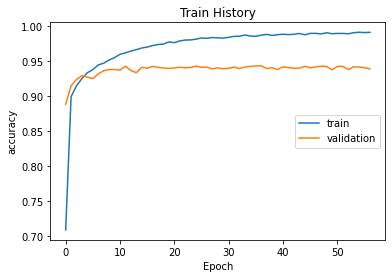

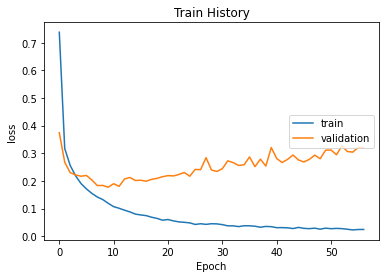

In [22]:
show_train_history(train_history, 'accuracy','val_accuracy')
show_train_history(train_history, 'loss','val_loss')

In [23]:
scores = model.evaluate(test_x, test_y)
print("loss =",scores[0],",acc = ",scores[1])

16721/16721 [==============================] - 6s 382us/step
loss = 0.30646742274876104 ,acc =  0.9397763013839722


In [27]:
predict_y = model.predict(test_x)

In [24]:
from keras.models import load_model
model = load_model('snake_cnn.h5')

## 其他模型 前處理

In [113]:
import numpy as np

# 表現不好
#numpy_data = np.array([snake_head_x,snake_head_y,food_x,food_y]) 
# 會自撞
#numpy_data = np.array([U,D,L,R])
# 模型訓練時還好 蛇蛇會自閉的躲到角落轉
#numpy_data = np.array([safe_U,safe_D,safe_L,safe_R])

#超級好
numpy_data = np.array([U,D,L,R,safe_U,safe_D,safe_L,safe_R])

X = np.transpose(numpy_data) 
y = Command

In [33]:
import pickle
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import  classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
# 輸出混淆矩陣、precision、recall、F1

def confusion_matrix(true,predict,size_x=5,size_y=5):
    true = np.array(true)
    predict = np.array(predict)
    matrix = pd.crosstab(true,predict,rownames=['true'],colnames=['predict'])
    fig, ax = plt.subplots(figsize=(size_x,size_y))
    sns.heatmap(matrix,                    
        annot=True,                
        square=True,               
        xticklabels=True,         
        yticklabels=True,         
        ax=ax)
    plt.show()   

In [118]:
# KNN

#資料劃分
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3)
#參數區間
param_grid = {'n_neighbors':[1, 2, 3]}
#交叉驗證 
cv = StratifiedShuffleSplit(n_splits=2, test_size=0.3)
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv, verbose=10, n_jobs=-1) #n_jobs為平行運算的數量
grid.fit(train_x, train_y)
grid_predictions = grid.predict(test_x)


Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    5.9s remaining:   11.9s
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    6.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:    6.1s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.1s finished


{'n_neighbors': 1}


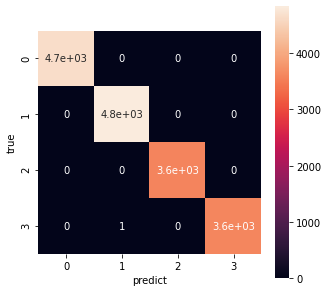

None
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4656
           1       1.00      1.00      1.00      4836
           2       1.00      1.00      1.00      3604
           3       1.00      1.00      1.00      3625

    accuracy                           1.00     16721
   macro avg       1.00      1.00      1.00     16721
weighted avg       1.00      1.00      1.00     16721



In [119]:
#最佳參數
print(grid.best_params_)
#預測結果
#print(grid_predictions)
#混淆矩陣
print(confusion_matrix(test_y, grid_predictions))
#分類結果
print(classification_report(test_y, grid_predictions))

In [120]:
#儲存
file = open('my_model_snake_knn.pickle', 'wb')
pickle.dump(model, file)
file.close()

In [121]:
# random forest


from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model.fit(train_x,train_y)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

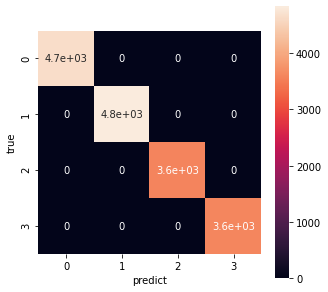

None
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4656
           1       1.00      1.00      1.00      4836
           2       1.00      1.00      1.00      3604
           3       1.00      1.00      1.00      3625

    accuracy                           1.00     16721
   macro avg       1.00      1.00      1.00     16721
weighted avg       1.00      1.00      1.00     16721



In [122]:
model_predictions = model.predict(test_x)
#混淆矩陣
print(confusion_matrix(test_y, model_predictions))
#分類結果
print(classification_report(test_y, model_predictions))

In [123]:
#儲存
file = open('my_model_snake_forest.pickle', 'wb')
pickle.dump(model, file)
file.close()